In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import e

In [ ]:
!/opt/bin/nvidia-smi

Fri Mar 17 06:51:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    34W /  70W |   4767MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class MyLoss(nn.Module):

    def __init__(self, in_features, out_features, loss_type='xlf', s=None, m=None):

        super(MyLoss, self).__init__()
        loss_type = loss_type.lower()
        assert loss_type in  ['xlf', 'xlf2']
        if loss_type == 'xlf':
            self.s = 45.0 if not s else s
            self.m = 0.05 if not m else m
        if loss_type == 'xlf2':
            self.s = 30.0 if not s else s
            self.m = 0 if not m else m
        self.loss_type = loss_type
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.eps = eps

    def forward(self, x, labels):
        '''
        input shape (N, in_features)
        '''
        assert len(x) == len(labels)
        assert torch.min(labels) >= 0
        assert torch.max(labels) < self.out_features
        
        for W in self.fc.parameters():
            W = F.normalize(W, p=2, dim=1)

        x = F.normalize(x, p=2, dim=1)

        wf = self.fc(x)
    

        if self.loss_type == 'xlf':
          wf = torch.acos(wf)
          numerator = torch.diagonal(wf.transpose(0, 1)[labels]) + 0.18
          excl = torch.cat([torch.cat((wf[i, :y], wf[i, y + 1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
          denominator = torch.exp(-1 * self.s * numerator) + torch.sum(torch.exp(-1 * self.s * excl), dim=1)
          L = torch.log(denominator) + self.s * numerator
          return torch.mean(L)


        if self.loss_type == 'xlf2':
          numerator = torch.diagonal(wf.transpose(0, 1)[labels])
          excl = torch.cat([torch.cat((wf[i, :y], wf[i, y + 1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
          denominator = torch.sum(torch.exp(excl), dim=1)
          dunk = torch.div(torch.pow(denominator, torch.div(1, numerator + 1e-6)), e)
          x = torch.div(1, dunk + 1e-7)
          L = torch.log(dunk) + x - 0.5 * torch.pow(x, 2) - 0.3333 * torch.pow(x, 3) + 0.25 * torch.pow(x, 4) - 0.2 * torch.pow(x, 5) + 0.1667 * torch.pow(x, 6) - 0.1429 * torch.pow(x, 7) + 0.125 * torch.pow(x, 8) - 0.1111 * torch.pow(x, 9) + 0.1 * torch.pow(x, 10)
          return  torch.mean(L)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch



class ConvBaseline(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvBaseline, self).__init__()
        self.convlayers = ConvNet()
        self.fc_final = nn.Linear(3, num_classes)

    def forward(self, x, embed=False):
        x = self.convlayers(x)
        if embed:
            return x
        x = self.fc_final(x)
        return x

class ConvAngularPen(nn.Module):
    def __init__(self, num_classes=10, loss_type='xlf'):
        super(ConvAngularPen, self).__init__()
        self.convlayers = ConvNet()
        self.adms_loss = MyLoss(3, num_classes, loss_type=loss_type)

    def forward(self, x, labels=None, embed=False):
        x = self.convlayers(x)
        if embed:
            return x
        L = self.adms_loss(x, labels)
        return L

    def predict(self, x):
        x = self.convlayers(x)
        x = F.normalize(x, p=2, dim=1)  # 标准化特征
        x = self.adms_loss.fc(x)  # 使用 adms_loss 的全连接层进行预测
        predicted_labels = torch.argmax(x, dim=1)
        return predicted_labels

class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(64))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(256))
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=8, stride=1))
        self.fc_projection = nn.Linear(512, 3)

    def forward(self, x, embed=False):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc_projection(x)
        return x

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 画三维图

def plot(embeds, labels, fig_path='./example.pdf'):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    r = 1
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
    x = r*sin(phi)*cos(theta)
    y = r*sin(phi)*sin(theta)
    z = r*cos(phi)
    ax.plot_surface(
        x, y, z,  rstride=1, cstride=1, color='w', alpha=0.3, linewidth=0)
    ax.scatter(embeds[:,0], embeds[:,1], embeds[:,2], c=labels, s=20)

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_aspect("auto")
    plt.tight_layout()
    plt.savefig(fig_path)

In [ ]:
import argparse
import os
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm

from torch.utils.data import random_split

In [ ]:
train_ds = datasets.FashionMNIST(root='./data',
                                 train=True,
                                 transform=transforms.Compose([transforms.ToTensor(),
                                                              transforms.Normalize(mean=(0.1307,), std=(0.3081,))]),
                                 download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
test_ds = datasets.FashionMNIST(root='./data',
                                train=False,
                                transform=transforms.Compose([transforms.ToTensor(),
                                                              transforms.Normalize(mean=(0.1307,),
                                                              std=(0.3081,))]),
                                download=True)

In [ ]:
batch_size = 512
train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=512,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_ds,
                                          batch_size=512,
                                          shuffle=True)

In [ ]:
os.makedirs('./figs', exist_ok=True)
device = "cuda"

In [ ]:
def train_baseline(train_loader):
    model = ConvBaseline().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    total_step = len(train_loader)
    for epoch in tqdm(range(num_epochs)):
        for i, (feats, labels) in enumerate(tqdm(train_loader)):
            feats = feats.to(device)
            labels = labels.to(device)
            out = model(feats)
            loss = criterion(out, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i + 1) % 100 == 0:
                print('Baseline: Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        if ((epoch + 1) % 8 == 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] / 4
    return model.cpu()

In [ ]:
def train_am(train_loader, loss_type):
    model = ConvAngularPen(loss_type=loss_type).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    total_step = len(train_loader)
    for epoch in tqdm(range(num_epochs)):
        for i, (feats, labels) in enumerate(tqdm(train_loader)):
            feats = feats.to(device)
            labels = labels.to(device)
            loss = model(feats, labels=labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i + 1) % 100 == 0:
                print('{}: Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(loss_type, epoch + 1, num_epochs, i + 1, total_step, loss.item()))

        if ((epoch + 1) % 8 == 0):
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] / 4

    return model.cpu()

In [ ]:
def get_embeds(model, loader):
    model = model.to(device).eval()
    full_embeds = []
    full_labels = []
    with torch.no_grad():
        for i, (feats, labels) in enumerate(loader):
            feats = feats[:100].to(device)
            full_labels.append(labels[:100].cpu().detach().numpy())
            embeds = model(feats, embed=True)
            full_embeds.append(F.normalize(embeds.detach().cpu()).numpy())
    model = model.cpu()
    return np.concatenate(full_embeds), np.concatenate(full_labels)

In [ ]:
def test_model(model, test_loader): #自定义Loss上的acc
    model = model.to(device).eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for feats, labels in test_loader:
            feats = feats.to(device)
            labels = labels.to(device)
            predicted_labels = model.predict(feats)
            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
    return correct / total

In [ ]:
def test(model, test_loader): #baseline上的acc
    model = model.to(device).eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for feats, labels in test_loader:
            feats = feats.to(device)
            labels = labels.to(device)
            outputs = model(feats)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
batch_size = 512
num_epochs = 60
lr = 0.001

Training xlf model....


 85%|████████▍ | 100/118 [00:24<00:04,  3.78it/s]

xlf: Epoch [1/60], Step [100/118], Loss: 5.4953



 85%|████████▍ | 100/118 [00:24<00:04,  3.91it/s]

xlf: Epoch [2/60], Step [100/118], Loss: 3.9781



 85%|████████▍ | 100/118 [00:24<00:04,  3.82it/s]

xlf: Epoch [3/60], Step [100/118], Loss: 2.1223



 85%|████████▍ | 100/118 [00:24<00:04,  3.68it/s]

xlf: Epoch [4/60], Step [100/118], Loss: 1.8801



 85%|████████▍ | 100/118 [00:24<00:04,  3.86it/s]

xlf: Epoch [5/60], Step [100/118], Loss: 1.3183



 85%|████████▍ | 100/118 [00:23<00:04,  3.90it/s]

xlf: Epoch [6/60], Step [100/118], Loss: 2.0282



 85%|████████▍ | 100/118 [00:24<00:04,  3.80it/s]

xlf: Epoch [7/60], Step [100/118], Loss: 0.9633



 85%|████████▍ | 100/118 [00:24<00:04,  3.89it/s]

xlf: Epoch [8/60], Step [100/118], Loss: 1.0351



 85%|████████▍ | 100/118 [00:24<00:04,  3.91it/s]

xlf: Epoch [9/60], Step [100/118], Loss: 0.4899



 85%|████████▍ | 100/118 [00:24<00:04,  3.85it/s]

xlf: Epoch [10/60], Step [100/118], Loss: 0.3796



 85%|████████▍ | 100/118 [00:24<00:04,  3.87it/s]

xlf: Epoch [11/60], Step [100/118], Loss: 0.2078



 85%|████████▍ | 100/118 [00:24<00:04,  3.73it/s]

xlf: Epoch [12/60], Step [100/118], Loss: 0.1604



 85%|████████▍ | 100/118 [00:24<00:04,  3.78it/s]

xlf: Epoch [13/60], Step [100/118], Loss: 0.1159



 85%|████████▍ | 100/118 [00:23<00:04,  3.89it/s]

xlf: Epoch [14/60], Step [100/118], Loss: 0.0280



 85%|████████▍ | 100/118 [00:25<00:04,  3.68it/s]

xlf: Epoch [15/60], Step [100/118], Loss: 0.0594



 85%|████████▍ | 100/118 [00:26<00:04,  3.65it/s]

xlf: Epoch [16/60], Step [100/118], Loss: 0.0278



 85%|████████▍ | 100/118 [00:23<00:04,  3.92it/s]

xlf: Epoch [17/60], Step [100/118], Loss: 0.0139



 85%|████████▍ | 100/118 [00:24<00:04,  3.86it/s]

xlf: Epoch [18/60], Step [100/118], Loss: 0.0227



 85%|████████▍ | 100/118 [00:24<00:04,  3.86it/s]

xlf: Epoch [19/60], Step [100/118], Loss: 0.0050



 85%|████████▍ | 100/118 [00:24<00:04,  3.71it/s]

xlf: Epoch [20/60], Step [100/118], Loss: 0.0068



 85%|████████▍ | 100/118 [00:24<00:04,  3.91it/s]

xlf: Epoch [21/60], Step [100/118], Loss: 0.0044



 85%|████████▍ | 100/118 [00:24<00:04,  3.92it/s]

xlf: Epoch [22/60], Step [100/118], Loss: 0.0042



 85%|████████▍ | 100/118 [00:24<00:04,  3.91it/s]

xlf: Epoch [23/60], Step [100/118], Loss: 0.0267



 85%|████████▍ | 100/118 [00:24<00:04,  3.91it/s]

xlf: Epoch [24/60], Step [100/118], Loss: 0.0033



 85%|████████▍ | 100/118 [00:24<00:04,  3.81it/s]

xlf: Epoch [25/60], Step [100/118], Loss: 0.0123



 85%|████████▍ | 100/118 [00:24<00:04,  3.85it/s]

xlf: Epoch [26/60], Step [100/118], Loss: 0.0041



 85%|████████▍ | 100/118 [00:24<00:04,  3.88it/s]

xlf: Epoch [27/60], Step [100/118], Loss: 0.0051



 85%|████████▍ | 100/118 [00:24<00:04,  3.90it/s]

xlf: Epoch [28/60], Step [100/118], Loss: 0.0029



 85%|████████▍ | 100/118 [00:24<00:04,  3.89it/s]

xlf: Epoch [29/60], Step [100/118], Loss: 0.0035



 85%|████████▍ | 100/118 [00:24<00:04,  3.77it/s]

xlf: Epoch [30/60], Step [100/118], Loss: 0.0039



 85%|████████▍ | 100/118 [00:24<00:04,  3.64it/s]

xlf: Epoch [31/60], Step [100/118], Loss: 0.0042



 85%|████████▍ | 100/118 [00:24<00:04,  3.90it/s]

xlf: Epoch [32/60], Step [100/118], Loss: 0.0036



 85%|████████▍ | 100/118 [00:24<00:04,  3.90it/s]

xlf: Epoch [33/60], Step [100/118], Loss: 0.0029



 85%|████████▍ | 100/118 [00:24<00:04,  3.92it/s]

xlf: Epoch [34/60], Step [100/118], Loss: 0.0032



 85%|████████▍ | 100/118 [00:24<00:04,  3.81it/s]

xlf: Epoch [35/60], Step [100/118], Loss: 0.0031



 85%|████████▍ | 100/118 [00:24<00:04,  3.89it/s]

xlf: Epoch [36/60], Step [100/118], Loss: 0.0047



 85%|████████▍ | 100/118 [00:24<00:04,  3.88it/s]

xlf: Epoch [37/60], Step [100/118], Loss: 0.0032



 85%|████████▍ | 100/118 [00:24<00:05,  3.55it/s]

xlf: Epoch [38/60], Step [100/118], Loss: 0.0029



 85%|████████▍ | 100/118 [00:24<00:04,  3.83it/s]

xlf: Epoch [39/60], Step [100/118], Loss: 0.0036



 85%|████████▍ | 100/118 [00:24<00:04,  3.70it/s]

xlf: Epoch [40/60], Step [100/118], Loss: 0.0034



 85%|████████▍ | 100/118 [00:24<00:04,  3.91it/s]

xlf: Epoch [41/60], Step [100/118], Loss: 0.0027



 85%|████████▍ | 100/118 [00:24<00:04,  3.85it/s]

xlf: Epoch [42/60], Step [100/118], Loss: 0.0032



 85%|████████▍ | 100/118 [00:24<00:04,  3.86it/s]

xlf: Epoch [43/60], Step [100/118], Loss: 0.0031



 85%|████████▍ | 100/118 [00:24<00:04,  3.83it/s]

xlf: Epoch [44/60], Step [100/118], Loss: 0.0027



 85%|████████▍ | 100/118 [00:24<00:04,  3.65it/s]

xlf: Epoch [45/60], Step [100/118], Loss: 0.0029



 85%|████████▍ | 100/118 [00:24<00:04,  3.88it/s]

xlf: Epoch [46/60], Step [100/118], Loss: 0.0037



 85%|████████▍ | 100/118 [00:24<00:04,  3.84it/s]

xlf: Epoch [47/60], Step [100/118], Loss: 0.0024



 85%|████████▍ | 100/118 [00:24<00:04,  3.93it/s]

xlf: Epoch [48/60], Step [100/118], Loss: 0.0027



 85%|████████▍ | 100/118 [00:24<00:04,  3.90it/s]

xlf: Epoch [49/60], Step [100/118], Loss: 0.0030



 85%|████████▍ | 100/118 [00:24<00:04,  3.80it/s]

xlf: Epoch [50/60], Step [100/118], Loss: 0.0031



 85%|████████▍ | 100/118 [00:24<00:04,  3.85it/s]

xlf: Epoch [51/60], Step [100/118], Loss: 0.0028



 85%|████████▍ | 100/118 [00:24<00:04,  3.80it/s]

xlf: Epoch [52/60], Step [100/118], Loss: 0.0028



 85%|████████▍ | 100/118 [00:24<00:04,  3.71it/s]

xlf: Epoch [53/60], Step [100/118], Loss: 0.0035



 85%|████████▍ | 100/118 [00:24<00:04,  3.85it/s]

xlf: Epoch [54/60], Step [100/118], Loss: 0.0349



 85%|████████▍ | 100/118 [00:24<00:04,  3.76it/s]

xlf: Epoch [55/60], Step [100/118], Loss: 0.0028



 85%|████████▍ | 100/118 [00:24<00:04,  3.87it/s]

xlf: Epoch [56/60], Step [100/118], Loss: 0.0033



 85%|████████▍ | 100/118 [00:24<00:04,  3.86it/s]

xlf: Epoch [57/60], Step [100/118], Loss: 0.0029



 85%|████████▍ | 100/118 [00:24<00:04,  3.66it/s]

xlf: Epoch [58/60], Step [100/118], Loss: 0.0034



 85%|████████▍ | 100/118 [00:24<00:04,  3.86it/s]

xlf: Epoch [59/60], Step [100/118], Loss: 0.0028



 85%|████████▍ | 100/118 [00:24<00:04,  3.89it/s]

xlf: Epoch [60/60], Step [100/118], Loss: 0.0027



100%|██████████| 60/60 [28:29<00:00, 28.50s/it]


Saved xlf figure
acc 0.9234


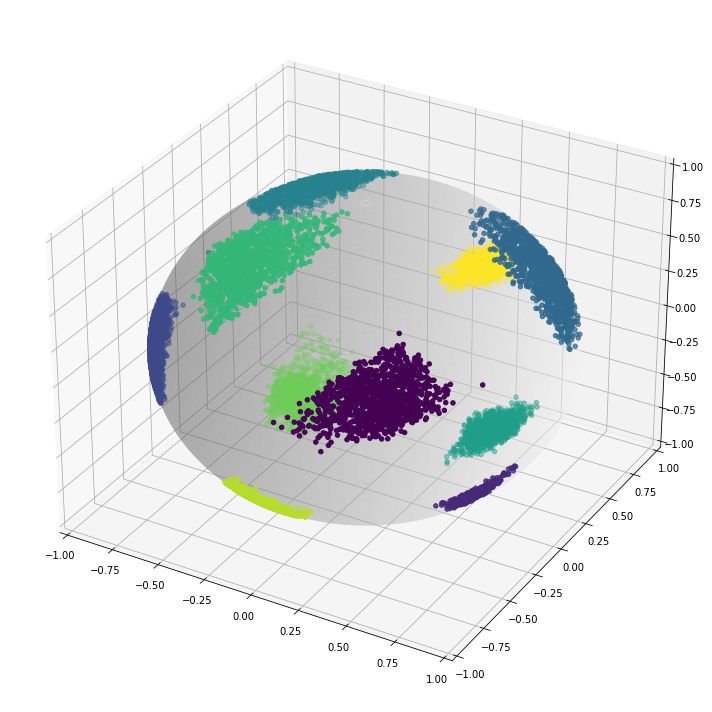

In [86]:
loss_types = ['xlf'] #loss_types = ['xlf','xlf2']
for loss_type in loss_types:
        print('Training {} model....'.format(loss_type))
        model_am = train_am(train_loader, loss_type)
        am_embeds, am_labels = get_embeds(model_am, train_loader)
        plot(am_embeds, am_labels, fig_path='./figs/{}.png'.format(loss_type))
        print('Saved {} figure'.format(loss_type))
        acc = test_model(model_am, test_loader)
        print('acc', acc)
        del model_am, am_embeds, am_labels

Training Baseline model....


 86%|████████▌ | 101/118 [00:12<00:02,  7.15it/s]

Baseline: Epoch [1/60], Step [100/118], Loss: 0.6130



 86%|████████▌ | 101/118 [00:12<00:02,  7.02it/s]

Baseline: Epoch [2/60], Step [100/118], Loss: 0.3936



 86%|████████▌ | 101/118 [00:12<00:02,  7.35it/s]

Baseline: Epoch [3/60], Step [100/118], Loss: 0.3244



 86%|████████▌ | 101/118 [00:12<00:02,  7.44it/s]

Baseline: Epoch [4/60], Step [100/118], Loss: 0.2429



 86%|████████▌ | 101/118 [00:11<00:02,  6.96it/s]

Baseline: Epoch [5/60], Step [100/118], Loss: 0.1936



 86%|████████▌ | 101/118 [00:11<00:02,  7.47it/s]

Baseline: Epoch [6/60], Step [100/118], Loss: 0.1631



 86%|████████▌ | 101/118 [00:11<00:02,  7.20it/s]

Baseline: Epoch [7/60], Step [100/118], Loss: 0.1539



 86%|████████▌ | 101/118 [00:11<00:02,  7.27it/s]

Baseline: Epoch [8/60], Step [100/118], Loss: 0.1073



 86%|████████▌ | 101/118 [00:11<00:02,  7.16it/s]

Baseline: Epoch [9/60], Step [100/118], Loss: 0.0266



 86%|████████▌ | 101/118 [00:11<00:02,  7.37it/s]

Baseline: Epoch [10/60], Step [100/118], Loss: 0.0073



 86%|████████▌ | 101/118 [00:11<00:02,  7.38it/s]

Baseline: Epoch [11/60], Step [100/118], Loss: 0.0059



 86%|████████▌ | 101/118 [00:11<00:02,  7.33it/s]

Baseline: Epoch [12/60], Step [100/118], Loss: 0.0033



 86%|████████▌ | 101/118 [00:11<00:02,  7.28it/s]

Baseline: Epoch [13/60], Step [100/118], Loss: 0.0020



 86%|████████▌ | 101/118 [00:11<00:02,  7.17it/s]

Baseline: Epoch [14/60], Step [100/118], Loss: 0.0019



 86%|████████▌ | 101/118 [00:11<00:02,  7.26it/s]

Baseline: Epoch [15/60], Step [100/118], Loss: 0.0012



 86%|████████▌ | 101/118 [00:11<00:02,  7.37it/s]

Baseline: Epoch [16/60], Step [100/118], Loss: 0.0013



 86%|████████▌ | 101/118 [00:11<00:02,  7.38it/s]

Baseline: Epoch [17/60], Step [100/118], Loss: 0.0010



 86%|████████▌ | 101/118 [00:11<00:02,  7.39it/s]

Baseline: Epoch [18/60], Step [100/118], Loss: 0.0010



 86%|████████▌ | 101/118 [00:11<00:02,  7.05it/s]

Baseline: Epoch [19/60], Step [100/118], Loss: 0.0008



 86%|████████▌ | 101/118 [00:11<00:02,  7.22it/s]

Baseline: Epoch [20/60], Step [100/118], Loss: 0.0008



 86%|████████▌ | 101/118 [00:11<00:02,  7.35it/s]

Baseline: Epoch [21/60], Step [100/118], Loss: 0.0007



 86%|████████▌ | 101/118 [00:12<00:02,  7.26it/s]

Baseline: Epoch [22/60], Step [100/118], Loss: 0.0010



 86%|████████▌ | 101/118 [00:11<00:02,  7.26it/s]

Baseline: Epoch [23/60], Step [100/118], Loss: 0.0009



 86%|████████▌ | 101/118 [00:12<00:02,  7.18it/s]

Baseline: Epoch [24/60], Step [100/118], Loss: 0.0006



 86%|████████▌ | 101/118 [00:11<00:02,  7.36it/s]

Baseline: Epoch [25/60], Step [100/118], Loss: 0.0006



 86%|████████▌ | 101/118 [00:11<00:02,  7.29it/s]

Baseline: Epoch [26/60], Step [100/118], Loss: 0.0006



 86%|████████▌ | 101/118 [00:11<00:02,  7.38it/s]

Baseline: Epoch [27/60], Step [100/118], Loss: 0.0005



 86%|████████▌ | 101/118 [00:12<00:02,  6.32it/s]

Baseline: Epoch [28/60], Step [100/118], Loss: 0.0005



 86%|████████▌ | 101/118 [00:12<00:03,  5.66it/s]

Baseline: Epoch [29/60], Step [100/118], Loss: 0.0006



 86%|████████▌ | 101/118 [00:11<00:02,  7.27it/s]

Baseline: Epoch [30/60], Step [100/118], Loss: 0.0005



 86%|████████▌ | 101/118 [00:11<00:02,  7.31it/s]

Baseline: Epoch [31/60], Step [100/118], Loss: 0.0008



 86%|████████▌ | 101/118 [00:11<00:02,  6.25it/s]

Baseline: Epoch [32/60], Step [100/118], Loss: 0.0005



 86%|████████▌ | 101/118 [00:11<00:02,  7.37it/s]

Baseline: Epoch [33/60], Step [100/118], Loss: 0.0007



 86%|████████▌ | 101/118 [00:11<00:02,  7.24it/s]

Baseline: Epoch [34/60], Step [100/118], Loss: 0.0006



 86%|████████▌ | 101/118 [00:12<00:02,  7.28it/s]

Baseline: Epoch [35/60], Step [100/118], Loss: 0.0005



 86%|████████▌ | 101/118 [00:11<00:02,  7.27it/s]

Baseline: Epoch [36/60], Step [100/118], Loss: 0.0005



 86%|████████▌ | 101/118 [00:11<00:02,  7.19it/s]

Baseline: Epoch [37/60], Step [100/118], Loss: 0.0006



 86%|████████▌ | 101/118 [00:11<00:02,  7.35it/s]

Baseline: Epoch [38/60], Step [100/118], Loss: 0.0007



 86%|████████▌ | 101/118 [00:11<00:02,  7.06it/s]

Baseline: Epoch [39/60], Step [100/118], Loss: 0.0006



 86%|████████▌ | 101/118 [00:11<00:02,  7.22it/s]

Baseline: Epoch [40/60], Step [100/118], Loss: 0.0005



 86%|████████▌ | 101/118 [00:11<00:02,  7.13it/s]

Baseline: Epoch [41/60], Step [100/118], Loss: 0.0005



 86%|████████▌ | 101/118 [00:11<00:02,  7.25it/s]

Baseline: Epoch [42/60], Step [100/118], Loss: 0.0005



 86%|████████▌ | 101/118 [00:11<00:02,  7.04it/s]

Baseline: Epoch [43/60], Step [100/118], Loss: 0.0004



 86%|████████▌ | 101/118 [00:11<00:02,  7.19it/s]

Baseline: Epoch [44/60], Step [100/118], Loss: 0.0005



 86%|████████▌ | 101/118 [00:11<00:02,  7.32it/s]

Baseline: Epoch [45/60], Step [100/118], Loss: 0.0006



 86%|████████▌ | 101/118 [00:12<00:02,  7.00it/s]

Baseline: Epoch [46/60], Step [100/118], Loss: 0.0004



 86%|████████▌ | 101/118 [00:11<00:02,  7.39it/s]

Baseline: Epoch [47/60], Step [100/118], Loss: 0.0006



 86%|████████▌ | 101/118 [00:11<00:02,  7.15it/s]

Baseline: Epoch [48/60], Step [100/118], Loss: 0.0005



 86%|████████▌ | 101/118 [00:11<00:02,  7.24it/s]

Baseline: Epoch [49/60], Step [100/118], Loss: 0.0008



 86%|████████▌ | 101/118 [00:12<00:02,  7.07it/s]

Baseline: Epoch [50/60], Step [100/118], Loss: 0.0004



 86%|████████▌ | 101/118 [00:11<00:02,  6.99it/s]

Baseline: Epoch [51/60], Step [100/118], Loss: 0.0005



 86%|████████▌ | 101/118 [00:11<00:02,  7.27it/s]

Baseline: Epoch [52/60], Step [100/118], Loss: 0.0004



 86%|████████▌ | 101/118 [00:12<00:02,  7.40it/s]

Baseline: Epoch [53/60], Step [100/118], Loss: 0.0005



 86%|████████▌ | 101/118 [00:11<00:02,  7.25it/s]

Baseline: Epoch [54/60], Step [100/118], Loss: 0.0006



 86%|████████▌ | 101/118 [00:12<00:02,  6.86it/s]

Baseline: Epoch [55/60], Step [100/118], Loss: 0.0005



 86%|████████▌ | 101/118 [00:11<00:02,  7.29it/s]

Baseline: Epoch [56/60], Step [100/118], Loss: 0.0006



 86%|████████▌ | 101/118 [00:12<00:02,  7.42it/s]

Baseline: Epoch [57/60], Step [100/118], Loss: 0.0005



 86%|████████▌ | 101/118 [00:11<00:02,  7.39it/s]

Baseline: Epoch [58/60], Step [100/118], Loss: 0.0005



 86%|████████▌ | 101/118 [00:12<00:02,  6.92it/s]

Baseline: Epoch [59/60], Step [100/118], Loss: 0.0006



 86%|████████▌ | 101/118 [00:12<00:02,  6.90it/s]

Baseline: Epoch [60/60], Step [100/118], Loss: 0.0004



100%|██████████| 60/60 [13:55<00:00, 13.93s/it]


Saved Baseline figure
acc 91.92


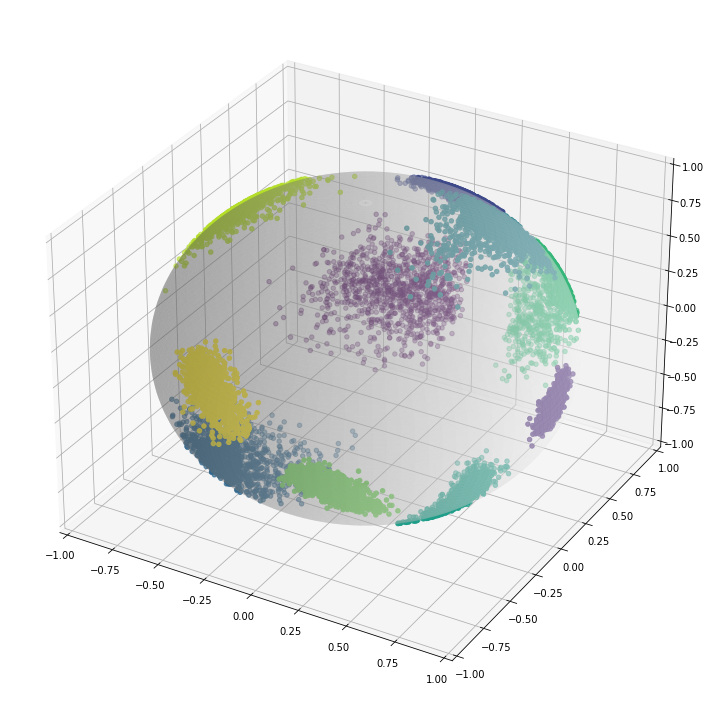

In [87]:
print('Training Baseline model....')
model_baseline = train_baseline(train_loader)
bl_embeds, bl_labels = get_embeds(model_baseline, train_loader)
plot(bl_embeds, bl_labels, fig_path='./figs/baseline.png')
print('Saved Baseline figure')
acc = test(model_baseline, test_loader)
print('acc', acc)
del model_baseline, bl_embeds, bl_labels